In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import math
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt

print(torch.__version__)

torch.manual_seed(123)  # add seed for reproducibility

2.2.2


In [3]:
win = 1.0
loss = -1.0
draw = -1.0

rows = 3
cols = 3

x = 1
o = 2
empty = 0

In [4]:
def get_move(model, board, player):
    board = board.flatten()
    player = torch.tensor([player])
    input_data = torch.cat((player, board))
    return model(input_data)


# this is the loss function for a tic tac toe model.
# predicition is the predicted best move of the model
# board is the current state that the board is in
# time is how many moves have been played
# winner is who ultimtely won the game

# CURRENT GOAL DONT PLACE IN SAME SPOT AS OTHER!!!!


filled_space_punishment = -10.0
resulted_in_loss_punishment = -1.0


def custom_loss(prediction, board, time, winner):
    prediction = prediction.flatten()
    board = board.flatten()
    player = x if time % 2 == 0 else o

    empty_slots_mask = (board != 0).float()
    loss = prediction * empty_slots_mask * filled_space_punishment

    max_value, max_index = torch.max(prediction, dim=0)

    if winner != player:
        loss[max_index] = resulted_in_loss_punishment * time + 1

    return torch.abs(torch.mean(loss))

In [5]:
class TicTacToeNetworkA(nn.Module):
    def __init__(self):
        super(TicTacToeNetworkA, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 80),
            nn.ReLU(),
            nn.Linear(80, 9),
            nn.Softmax(),
        )

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.flatten(x)
        x = self.layers(x)
        return x


modelA = TicTacToeNetworkA()
optimizerA = optim.Adam(modelA.parameters(), lr=0.0001)
criterionA = custom_loss

In [6]:
class TicTacToeNetworkB(nn.Module):
    def __init__(self):
        super(TicTacToeNetworkB, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(10, 800),
            nn.ReLU(),
            nn.Linear(800, 80),
            nn.ReLU(),
            nn.Linear(80, 9),
        )

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.flatten(x)
        x = self.layers(x)
        return x


modelB = TicTacToeNetworkB()
optimizerB = optim.Adam(modelA.parameters(), lr=0.0001, amsgrad=True)
criterionB = custom_loss

In [7]:
def user(dummy_var):
    while True:
        row = int(input(f"Enter row (0-{rows-1}): "))
        if row < rows and row >= 0:
            break

    while True:
        col = int(input(f"Enter col (0-{cols-1}): "))
        if col < cols and col >= 0:
            break

    board = torch.ones(rows, cols)
    board = board * empty

    board[row][col] = 1

    return board.view(1, 9)

In [8]:
def checkForWin(board):
    for row in board:
        if torch.all(row == x):
            return x
        elif torch.all(row == o):
            return o

    for col in range(0, cols):
        col = board[:, col]
        if torch.all(col == x):
            return x
        elif torch.all(col == o):
            return o

    truth = board == o
    if truth[0][0] and truth[1][1] and truth[2][2]:
        return o
    elif truth[0][2] and truth[1][1] and truth[2][0]:
        return o

    truth = board == x
    if truth[0][0] and truth[1][1] and truth[2][2]:
        return x
    elif truth[0][2] and truth[1][1] and truth[2][0]:
        return x

    return empty


def print_tic_tac_toe_board(board):
    for row in range(3):
        # Print horizontal lines between rows
        if row != 0:
            print("-" * cols * 3)

        for col in range(3):
            # Print vertical lines between columns
            if col != 0:
                print("|", end=" ")

            # Print the cell value
            if board[row][col] == 0:
                print(" ", end=" ")
            elif board[row][col] == 1:
                print("X", end=" ")
            elif board[row][col] == 2:
                print("O", end=" ")

        print()  # Move to the next line after printing each row
    print()


def run_game(playerA, playerB, show_game=False):
    game = torch.ones(rows * cols, rows, cols)
    game = game * empty

    for i in range(0, rows * cols):
        icon = empty

        if (i % 2) == 0:
            icon = x
            move = get_move(playerA, game[i], icon)
        else:
            icon = o
            move = get_move(playerB, game[i], icon)
            print(move)

        row, col = interprateMove(move)

        if game[i][row][col] == empty:
            for j in range(i, rows * cols):
                game[j][row][col] = icon
        else:
            if show_game:
                print("Unable to go there. Turn Lost")

        if show_game:
            print_tic_tac_toe_board(game[i])

        if checkForWin(game[i]):
            return checkForWin(game[i]), game

    return checkForWin(game[i]), game


def interprateMove(move):
    probs = F.softmax(move, dim=1)
    flat_indices = torch.argmax(probs.view(-1))
    original_indices = torch.unravel_index(flat_indices, move.shape)
    _, flat_index = original_indices
    row = math.floor(flat_index / rows)
    col = (flat_index % rows).item()
    return row, col

/Users/blaineh2/opt/miniforge3/envs/temp/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[-0.0248, -0.0316, -0.0466, -0.1776, -0.0209, -0.0455, -0.0389, -0.0696,
         -0.0800]], grad_fn=<AddmmBackward0>)
tensor([[-3.8356e-02, -1.1531e-01,  5.9925e-05, -3.5595e-01, -8.0012e-02,
         -5.8802e-02, -7.2424e-03, -8.1128e-02, -7.7183e-02]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.0297, -0.1094, -0.0721, -0.4656, -0.0344, -0.0424, -0.0128, -0.0869,
         -0.0486]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0334, -0.0482, -0.0155, -0.4988, -0.0204, -0.0199,  0.0938, -0.1484,
         -0.0569]], grad_fn=<AddmmBackward0>)
tensor([[-0.0248, -0.0316, -0.0466, -0.1776, -0.0209, -0.0455, -0.0389, -0.0696,
         -0.0800]], grad_fn=<AddmmBackward0>)
tensor([[-0.0243, -0.1021,  0.0109, -0.3294, -0.0891, -0.0286, -0.0136, -0.0215,
         -0.0666]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0261, -0.0795, -0.0506, -0.4449, -0.0301, -0.0135, -0.0236, -0.0631,
         -0.0412]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0313, -0.0231, -0.0019, -0.4906, -0.0041, -0.0029,  0.07

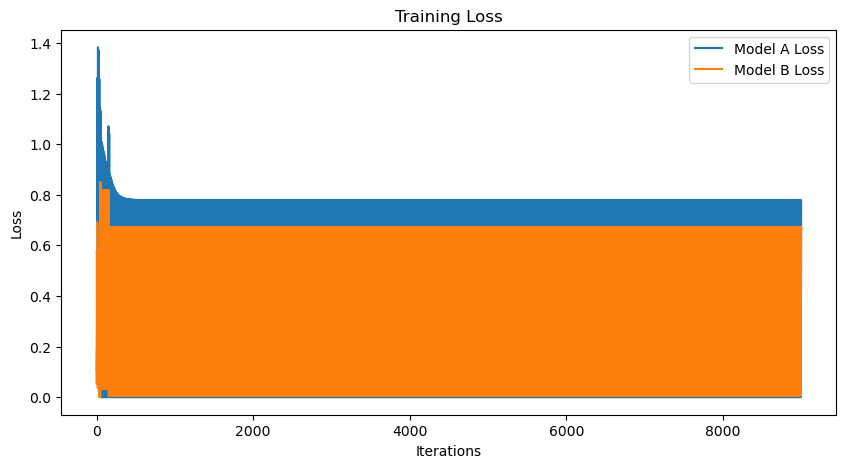

In [9]:
lossesA = []  # List to store loss values for modelA
lossesB = []  # List to store loss values for modelB

for i in range(1000):  # Increase the number of training iterations
    models = (modelA, modelB)
    criterion = (criterionA, criterionB)
    optimizer = (optimizerA, optimizerB)

    optimizer[0].zero_grad()
    optimizer[1].zero_grad()

    # Run an iteration of a game
    winner, game = run_game(models[0], models[1], show_game=False)

    # Train the models on the game results
    for i, board in enumerate(game):
        player = x if i % 2 == 0 else o
        predictionA = get_move(models[0], board, player)
        predictionB = get_move(models[1], board, player)

        last_board = game[i - 1] if i != 0 else torch.ones(rows, cols) * empty

        lossA = criterion[0](predictionA, board=last_board, time=i, winner=winner)
        lossB = criterion[1](predictionB, board=last_board, time=i, winner=winner)

        lossA.backward()
        lossB.backward()
        optimizer[0].step()
        optimizer[1].step()

        # Append the loss values to the lists
        lossesA.append(lossA.item())
        lossesB.append(lossB.item())

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(lossesA, label="Model A Loss")
plt.plot(lossesB, label="Model B Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [10]:
# winner,_ = run_game(user, modelB, True)

print(f"player {winner} is the winner!")

player 0 is the winner!


In [11]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import torch.nn as nn
# import math
# from collections import namedtuple, deque
# import random
# import matplotlib.pyplot as plt

# win = 1.0
# loss = -1.0
# draw = -1.0

# rows = 3
# cols = 3

# x = 1
# o = 2
# empty = 0

# def get_move(model, board, player):
#     board = board.flatten()
#     player = torch.tensor([player])
#     input_data = torch.cat((player, board))
#     return model(input_data)

# # this is the loss function for a tic tac toe model.
# # predicition is the predicted best move of the model
# # board is the current state that the board is in
# # time is how many moves have been played
# # winner is who ultimtely won the game

# #CURRENT GOAL DONT PLACE IN SAME SPOT AS OTHER!!!!

# filled_space_punishment = -10.0
# resulted_in_loss_punishment = -1.0

# def custom_loss(prediction, board, time, winner):
#     prediction = prediction.flatten()
#     board = board.flatten()
#     player = x if time % 2 == 0 else o

#     empty_slots_mask = (board != 0).float()
#     loss = prediction * empty_slots_mask * filled_space_punishment

#     max_value, max_index = torch.max(prediction, dim=0)

#     if winner != player:
#         loss[max_index] = resulted_in_loss_punishment * time + 1

#     return torch.abs(torch.mean(loss))

# class TicTacToeNetworkA(nn.Module):
#     def __init__(self):
#         super(TicTacToeNetworkA, self).__init__()
#         self.flatten = nn.Flatten()
#         self.layers = nn.Sequential(
#             nn.Linear(10, 8),
#             nn.ReLU(),
#             nn.Linear(8, 8),
#             nn.ReLU(),
#             nn.Linear(8, 9),
#             nn.Softmax()
#         )

#     def forward(self, x):
#         x = x.unsqueeze(0)
#         x = self.flatten(x)
#         x = self.layers(x)
#         return x

# modelA = TicTacToeNetworkA()
# optimizerA = optim.Adam(modelA.parameters(), lr=0.000001)
# criterionA = custom_loss

# class TicTacToeNetworkB(nn.Module):
#     def __init__(self):
#         super(TicTacToeNetworkB, self).__init__()
#         self.flatten = nn.Flatten()
#         self.layers = nn.Sequential(
#             nn.Linear(10, 8000),
#             nn.ReLU(),
#             nn.Linear(8000, 800),
#             nn.ReLU(),
#             nn.Linear(800, 9),
#             nn.Softmax()
#         )

#     def forward(self, x):
#         x = x.unsqueeze(0)
#         x = self.flatten(x)
#         x = self.layers(x)
#         return x

# modelB = TicTacToeNetworkB()
# optimizerB = optim.Adam(modelA.parameters(), lr=0.001, amsgrad=True)
# criterionB = custom_loss

# def checkForWin(board):
#     for row in board:
#         if torch.all(row == x):
#             return x
#         elif torch.all(row == o):
#             return o

#     for col in range(0, cols):
#         col = board[:,col]
#         if torch.all(col == x):
#             return x
#         elif torch.all(col == o):
#             return o

#     truth = board == o
#     if truth[0][0] and truth[1][1] and truth[2][2]:
#         return o
#     elif truth[0][2] and truth[1][1] and truth[2][0]:
#         return o

#     truth = board == x
#     if truth[0][0] and truth[1][1] and truth[2][2]:
#         return x
#     elif truth[0][2] and truth[1][1] and truth[2][0]:
#         return x

#     return empty

# def print_tic_tac_toe_board(board):
#     for row in range(3):
#         # Print horizontal lines between rows
#         if row != 0:
#             print("-" * cols  * 3)

#         for col in range(3):
#             # Print vertical lines between columns
#             if col != 0:
#                 print("|", end=" ")

#             # Print the cell value
#             if board[row][col] == 0:
#                 print(" ", end=" ")
#             elif board[row][col] == 1:
#                 print("X", end=" ")
#             elif board[row][col] == 2:
#                 print("O", end=" ")

#         print()  # Move to the next line after printing each row
#     print()


# def run_game(playerA, playerB, show_game=False):
#     game = torch.ones(rows*cols, rows,cols)
#     game = game * empty

#     for i in range(0, rows * cols):
#         icon = empty

#         if (i % 2) == 0:
#             icon = x
#             move = get_move(playerA, game[i], icon)
#         else:
#             icon = o
#             move = get_move(playerB, game[i], icon)

#         row, col = interprateMove(move)

#         if game[i][row][col] == empty:
#             for j in range(i,rows*cols):
#                 game[j][row][col] = icon
#         else:
#             if show_game: print("Unable to go there. Turn Lost")


#         if show_game: print_tic_tac_toe_board(game[i])

#         if checkForWin(game[i]):
#             return checkForWin(game[i]), game

#     return checkForWin(game[i]), game


# def interprateMove(move):
#     probs = F.softmax(move, dim=1)
#     flat_indices = torch.argmax(probs.view(-1))
#     original_indices = torch.unravel_index(flat_indices, move.shape)
#     _, flat_index = original_indices
#     row = math.floor(flat_index / rows)
#     col = (flat_index % rows).item()
#     return row, col


# lossesA = []  # List to store loss values for modelA
# lossesB = []  # List to store loss values for modelB

# for i in range(0, 10):
#     models = (modelA, modelB)
#     criterion = (criterionA, criterionB)
#     optimizer = (optimizerA, optimizerB)

#     # run an iteration of a game
#     winner, game = run_game(models[0], models[1], True)

#     # train the models on the game results
#     for i, board in enumerate(game):
#         player = x if i % 2 == 0 else o
#         # we can train them both on each other's moves speeding up the learning time
#         predictionA = get_move(models[0], board, player)
#         predictionB = get_move(models[1], board, player)

#         last_board = torch.ones(rows, cols) * empty

#         if i != 0:
#             last_board = game[i-1]

#         lossA = criterion[0](predictionA, board=last_board, time=i, winner=winner)
#         lossB = criterion[1](predictionB, board=last_board, time=i, winner=winner)

#         optimizer[0].zero_grad()
#         optimizer[1].zero_grad()
#         lossA.backward()
#         lossB.backward()
#         optimizer[0].step()
#         optimizer[1].step()

#         # Append the loss values to the lists
#         lossesA.append(lossA.item())
#         lossesB.append(lossB.item())

# # Plot the loss values
# plt.figure(figsize=(10, 5))
# plt.plot(lossesA, label='Model A Loss')
# plt.plot(lossesB, label='Model B Loss')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()
# plt.show()